# Global revenue time series analysis

## Imports 

In [1]:

from datetime import datetime

import numpy as np 
import pandas as pd

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


import plotly.express as px
import plotly.graph_objects as go
from prophet import Prophet

# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
calendar= pd.read_csv('DS_market_data\daily_calendar_with_events.csv')
prices= pd.read_csv('DS_market_data\item_prices.zip')
sales= pd.read_csv('DS_market_data\item_sales.zip')

In [3]:
#dollar value table
dollar= pd.read_csv('DS_market_data\dollar_value_table.csv', index_col=0)

## Preparing the data

In [4]:
dollar.head()

,id,unit_sold,price,revenue,item,date
0,ACCESORIES_1_001_NYC_1,0,11.02,0.00,ACCESORIES_1_001,2011-01-29
1,ACCESORIES_1_002_NYC_1,0,5.28,0.00,ACCESORIES_1_002,2011-01-29
2,ACCESORIES_1_003_NYC_1,0,3.95,0.00,ACCESORIES_1_003,2011-01-29
3,ACCESORIES_1_004_NYC_1,0,6.02,0.00,ACCESORIES_1_004,2011-01-29
4,ACCESORIES_1_005_NYC_1,0,3.91,0.00,ACCESORIES_1_005,2011-01-29


In [5]:
dollar['unit_sold'].describe()

count   58,327,370.00
mean             1.11
std              3.67
min           -128.00
25%              0.00
50%              0.00
75%              1.00
max            127.00
Name: unit_sold, dtype: float64

In [ ]:
#removing negative values
dollar = dollar[dollar.unit_sold>=0]

In [5]:
dollar['revenue'] = dollar['revenue'].astype("float16")
dollar['date'] = pd.to_datetime(dollar['date'])
dollar['day-of-week'] = dollar['date'].dt.day_name()
dollar['quarter'] = dollar['date'].dt.quarter

## Revenue per day of the week 

In [ ]:
#Plotting the sales per day of the week
fig = px.line(dollar, x="date", y="revenue", color='day-of-week', title='Total revenue over time by Day of Week')
fig.show()

In [ ]:
fig = px.histogram(dollar, x='day-of-week', y="revenue", color = 'quarter', title="Revenu by Day of the Week")
fig.show()

## Prophet model for trend and seasonality analysis
Revenue analysis using Prophet 

In [18]:
revenue_pred = dollar.pivot_table(index=['date'], values='revenue', aggfunc=[np.sum]).reset_index()

In [19]:
revenue_pred.columns = revenue_pred.columns.get_level_values(0)
revenue_pred.head()

,date,sum
0,2011-01-29,"104,721.30"
1,2011-01-30,"101,197.55"
2,2011-01-31,"73,762.92"
3,2011-02-01,"78,025.36"
4,2011-02-02,"60,183.35"


In [20]:
revenue_pred.rename(columns={'sum': 'y'}, inplace=True)
revenue_pred.rename(columns={'date': 'ds'}, inplace=True)
revenue_pred['ds'] = pd.to_datetime(revenue_pred['ds'])
revenue_pred.head()

,ds,y
0,2011-01-29,"104,721.30"
1,2011-01-30,"101,197.55"
2,2011-01-31,"73,762.92"
3,2011-02-01,"78,025.36"
4,2011-02-02,"60,183.35"


In [21]:
m = Prophet()
m.fit(revenue_pred)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-29,"79,478.68","88,242.13","119,526.41","79,478.68","79,478.68","24,249.77","24,249.77","24,249.77","25,362.34","25,362.34","25,362.34","-1,112.58","-1,112.58","-1,112.58",0.00,0.00,0.00,"103,728.44"
1,2011-01-30,"79,535.76","90,613.21","119,718.34","79,535.76","79,535.76","24,995.97","24,995.97","24,995.97","25,761.42","25,761.42","25,761.42",-765.45,-765.45,-765.45,0.00,0.00,0.00,"104,531.73"
2,2011-01-31,"79,592.85","59,297.28","88,381.80","79,592.85","79,592.85","-5,095.11","-5,095.11","-5,095.11","-4,693.33","-4,693.33","-4,693.33",-401.77,-401.77,-401.77,0.00,0.00,0.00,"74,497.75"
3,2011-02-01,"79,649.94","49,275.86","80,473.51","79,649.94","79,649.94","-14,407.16","-14,407.16","-14,407.16","-14,385.43","-14,385.43","-14,385.43",-21.73,-21.73,-21.73,0.00,0.00,0.00,"65,242.78"
4,2011-02-02,"79,707.03","48,464.64","79,167.44","79,707.03","79,707.03","-15,265.27","-15,265.27","-15,265.27","-15,639.14","-15,639.14","-15,639.14",373.87,373.87,373.87,0.00,0.00,0.00,"64,441.76"


## Visualization of results

In [22]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

## Break down the results

In [23]:
plot_components_plotly(m, forecast)

## Adding Hollidays to the model

In [24]:
calendar.fillna(0, inplace=True)

holidays = calendar.loc[calendar['event'] != 0].reset_index()
holidays.rename(columns={'date':'ds'}, inplace=True)
holidays.rename(columns={'event':'holiday'}, inplace=True)


holidays.head()

,index,ds,weekday,weekday_int,d,holiday
0,8,2011-02-06,Sunday,2,d_9,SuperBowl
1,184,2011-08-01,Monday,3,d_185,Ramadan starts
2,299,2011-11-24,Thursday,6,d_300,Thanksgiving
3,337,2012-01-01,Sunday,2,d_338,NewYear
4,372,2012-02-05,Sunday,2,d_373,SuperBowl


In [25]:
to_drop = ['index','weekday', 'weekday_int']
holidays = holidays.drop(to_drop, axis=1)

In [26]:
holidays = holidays.assign(lower_window = 0 ,upper_window=1)

In [27]:
# Looking at the hollidays in the calendar df
holidays['holiday'].value_counts()

SuperBowl         6
Easter            5
NewYear           5
Ramadan starts    5
Thanksgiving      5
Name: holiday, dtype: int64

In [28]:
m = Prophet(holidays=holidays)
forecast = m.fit(revenue_pred).predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
# Looking at the impact of hollidays and events on the model
forecast[(forecast['SuperBowl'] + forecast['Ramadan starts'] + forecast['NewYear'] + forecast['Thanksgiving'] + forecast['Easter']).abs() > 0][
    ['ds', 'SuperBowl', 'Ramadan starts','NewYear','Thanksgiving','Easter']][-10:]

,ds,SuperBowl,Ramadan starts,NewYear,Thanksgiving,Easter
1601,2015-06-18,0.00,331.10,0.00,0.00,0.00
1602,2015-06-19,0.00,"-1,771.73",0.00,0.00,0.00
1762,2015-11-26,0.00,0.00,0.00,"-34,433.28",0.00
1763,2015-11-27,0.00,0.00,0.00,"-29,033.26",0.00
1798,2016-01-01,0.00,0.00,"-21,056.54",0.00,0.00
1799,2016-01-02,0.00,0.00,"16,658.10",0.00,0.00
1835,2016-02-07,"-1,754.40",0.00,0.00,0.00,0.00
1836,2016-02-08,"-1,295.60",0.00,0.00,0.00,0.00
1884,2016-03-27,0.00,0.00,0.00,0.00,"-16,780.13"
1885,2016-03-28,0.00,0.00,0.00,0.00,"-3,822.54"


In [30]:
plot_components_plotly(m, forecast)

## Using Prophet built-in collection of country-specific holidays 

In [31]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(revenue_pred)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
m.train_holiday_names

0                       SuperBowl
1                  Ramadan starts
2                    Thanksgiving
3                         NewYear
4                          Easter
5                  New Year's Day
6      Martin Luther King Jr. Day
7           Washington's Birthday
8                    Memorial Day
9                Independence Day
10                      Labor Day
11                   Columbus Day
12                   Veterans Day
13                  Christmas Day
14       Christmas Day (Observed)
15      New Year's Day (Observed)
16        Veterans Day (Observed)
17    Independence Day (Observed)
dtype: object

In [33]:
forecast = m.predict(future)

plot_components_plotly(m, forecast)

In [34]:
df_1wk = revenue_pred.iloc[:7]
df_1wk

,ds,y
0,2011-01-29,"104,721.30"
1,2011-01-30,"101,197.55"
2,2011-01-31,"73,762.92"
3,2011-02-01,"78,025.36"
4,2011-02-02,"60,183.35"
5,2011-02-03,"89,083.15"
6,2011-02-04,"88,260.41"


In [35]:
#checking values for specific weeks
forecast[forecast['ds'] == '2011-02-04'][['ds', 'yhat']]


,ds,yhat
6,2011-02-04,"80,868.96"


### Fourier Order of Seasonalities
Seasonalities are estimated using a partial Fourier sum. The number of terms in the partial sum(the order) is a parameter that determines how quickly the seasonality can change.


The default Fourier order for yearly seasonality is 10. The default values are often appropriate, but they can be increased when the seasonality needs to fit higher-frequency changes, and generally be less smooth. The Fourier order can be specified for each built-in seasonality when instantiating the model, here it is increased to 20.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


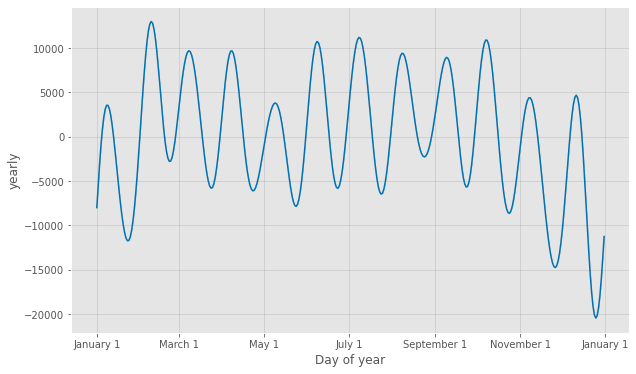

In [36]:
from prophet.plot import plot_yearly
m_yearly = Prophet(yearly_seasonality=20).fit(revenue_pred)
a = plot_yearly(m_yearly)